     RLC 串联谐振 (U2/U1) 拟合分析报告
【拟合参数】
  谐振频率 f0 : 15751.31 Hz
  品质因数 Q  : 9.9658
  峰值比值 A  : 0.5049
---------------------------------------------
【频带宽度】
  下半功率点 f1: 14980.85 Hz
  上半功率点 f2: 16561.38 Hz
  带宽 (f2-f1) : 1580.53 Hz


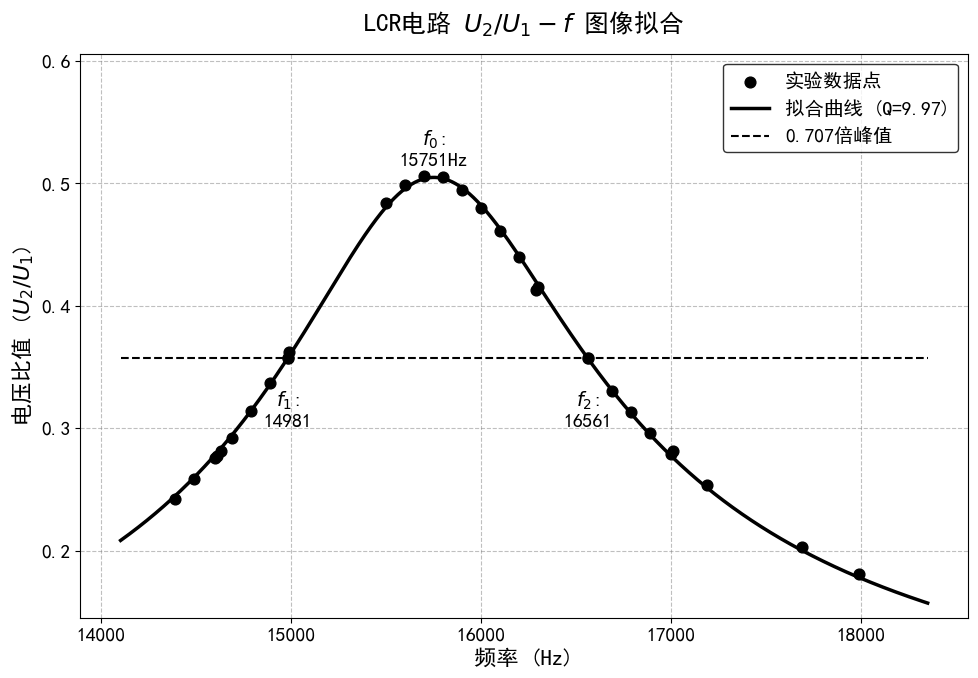

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ================= 1. 数据录入区域 =================
# 频率 f (Hz)
f_data = np.array([
    15900, 15800, 15700, 15600, 15500, 16000, 16100, 16200, 16300, 
    14600, 14610, 14630, 17000, 17010, 17190, 17690, 17990, 14390, 
    14690, 16690, 16290, 14490, 14990, 14890, 14790, 16790, 16890
])

# 总电压 U1 (V)
U1_data = np.array([
    0.946, 0.936, 0.935, 0.943, 0.958, 0.961, 0.983, 1.007, 1.035, 
    1.207, 1.204, 1.200, 1.200, 1.201, 1.231, 1.290, 1.315, 1.248, 
    1.187, 1.204, 1.204, 1.204, 1.204, 1.204, 1.204, 1.204, 1.204
])

# 电阻电压 U2 (V)
U2_data = np.array([
    0.468, 0.473, 0.473, 0.470, 0.464, 0.461, 0.453, 0.443, 0.430, 
    0.3326, 0.3342, 0.3373, 0.335, 0.338, 0.3123, 0.2621, 0.238, 0.3017, 
    0.3466, 0.398, 0.497, 0.311, 0.436, 0.406, 0.378, 0.377, 0.356
])

# 自动计算电压比值 (U2 / U1)
ratio_data = U2_data / U1_data

# ================= 2. 定义物理模型 =================
def transfer_function(f, f0, Q, A):
    """
    RLC 串联电路电压传输比函数
    A: 峰值比率
    """
    detuning = Q * (f / f0 - f0 / f)
    return A / np.sqrt(1 + detuning**2)

# ================= 3. 执行拟合 =================
max_idx = np.argmax(ratio_data)
# 初始猜测: 频率取最大值点，Q猜5，A猜最大比值
p0_guess = [f_data[max_idx], 5.0, ratio_data[max_idx]]

try:
    popt, pcov = curve_fit(transfer_function, f_data, ratio_data, p0=p0_guess)
    f0_fit, Q_fit, A_fit = popt
except Exception as e:
    print(f"拟合失败: {e}")
    exit()

# ================= 4. 计算半功率点 =================
cutoff_val = A_fit / np.sqrt(2)

delta_f = f0_fit / Q_fit
f1_fit = np.sqrt(f0_fit**2 + (delta_f/2)**2) - delta_f/2
f2_fit = np.sqrt(f0_fit**2 + (delta_f/2)**2) + delta_f/2
bw_fit = f2_fit - f1_fit

# ================= 5. 输出实验报告 =================
print("="*45)
print("     RLC 串联谐振 (U2/U1) 拟合分析报告")
print("="*45)
print(f"【拟合参数】")
print(f"  谐振频率 f0 : {f0_fit:.2f} Hz")
print(f"  品质因数 Q  : {Q_fit:.4f}")
print(f"  峰值比值 A  : {A_fit:.4f}")
print("-" * 45)
print(f"【频带宽度】")
print(f"  下半功率点 f1: {f1_fit:.2f} Hz")
print(f"  上半功率点 f2: {f2_fit:.2f} Hz")
print(f"  带宽 (f2-f1) : {bw_fit:.2f} Hz")
print("="*45)

# ================= 6. 绘图 (全黑白 & 大字体优化) =================
f_smooth = np.linspace(min(f_data)*0.98, max(f_data)*1.02, 2000)
ratio_smooth = transfer_function(f_smooth, *popt)

plt.figure(figsize=(10, 7))

# 全局字体设置
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei']  # 必须设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号

# 1. 画实验数据点 (黑色散点)
plt.scatter(f_data, ratio_data, color='black', s=60, label='实验数据点', zorder=5)

# 2. 画拟合曲线 (黑色实线)
plt.plot(f_smooth, ratio_smooth, color='black', linewidth=2.5, label=f'拟合曲线 (Q={Q_fit:.2f})')

# 3. 画 0.707 截断线 (黑色虚线)
plt.hlines(cutoff_val, min(f_smooth), max(f_smooth), linestyles='dashed', colors='black', linewidth=1.5, label='0.707倍峰值')

# 4. 标记 f1, f2 (黑色圆点)
plt.plot([f1_fit, f2_fit], [cutoff_val]*2, 'o', color='black', markersize=8)

# 5. 添加文本标注 (黑色文本)
y_offset = A_fit * 0.05  # 动态计算偏移量

# f1 标注 (放在点下方)
plt.text(f1_fit, cutoff_val - y_offset, f'$f_1$:\n{f1_fit:.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')

# f2 标注 (放在点下方)
plt.text(f2_fit, cutoff_val - y_offset, f'$f_2$:\n{f2_fit:.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')

# f0 标注 (放在峰值上方)
plt.text(f0_fit, A_fit + y_offset * 0.3, f'$f_0$:\n{f0_fit:.0f}Hz', 
         ha='center', va='bottom', color='black', fontsize=14, fontweight='bold')

# 装饰图表
plt.title('LCR电路 $U_2/U_1 - f$ 图像拟合', fontsize=18, pad=15, color='black')
plt.xlabel('频率 (Hz)', fontsize=16, color='black')
plt.ylabel('电压比值 ($U_2/U_1$)', fontsize=16, color='black')

# 刻度设置 (字体加大)
plt.tick_params(axis='both', which='major', labelsize=14, colors='black')

# 【关键步骤】设置 Y 轴范围：
# 底部留一点空间，顶部留 20% 的余量，确保 f0 的字不会跑到图外面去
plt.ylim(min(ratio_data)*0.8, A_fit * 1.20)

# 图例 (去边框，纯黑)
plt.legend(loc='best', fontsize=14, edgecolor='black', labelcolor='black')

plt.grid(True, which='both', linestyle='--', alpha=0.5, color='gray')
plt.tight_layout()

plt.show()